# Named Entity Recognition Model using Pytorch and Hugging Face Transformers

Will create a NER model that will extract company names from emails using custom neural network models, transformers, and hybrid models using Pytorch and HuggingFace.

</br></br>

- Import Libararies and Dependencies
  - Fetch and load kaggle ner dataset
  - Load CoNLL03 dataset
  - Load Job Data
- Clean and Combine Datasets
  - Transform datasets to standard form
  - Fill null values, drop irrelevant columns, drop duplicates
  - Convert NER tags to numerical values
  - Combine all datasets to one dataframe
- Exploratory Data Analysis (EDA)
  - Visualize NER tags by count
  - Plot distribution of sentence lengths in dataset
  - Visualize most common words per NER tag
- Preprocess Data
  - Tokenize data with BertTokenizer
  - Store data into Pytorch DataLoader object
- Create and Define Model Architectures
  - Implement a baseline Bi-LSTM neural network
  - Implement a Gated Convolution Neural Network
  - Import a BERT based model from HuggingFace
- Train Models
  - Create training function for standard neural network models
  - Create training function for BERT based model
- Model Evaluation
  - Compare metrics between 3 models
  - Plot confusion matrices and metrics
- Hyperparameter Tuning
  - Tune hyperparameters of highest scoring model
- Save Model
  - Save model weights as pickle file
  - Deploy model

</br></br>

### Import Libaries and Dependencies
---

In [ ]:
!pip install tensorflow-addons==0.23.0
!pip install tf2crf keras_crf
!pip install gdown==4.5.4 --no-cache-dir
!pip install datasets
!pip install kaggle
#https://arxiv.org/pdf/1812.09449.pdf

In [ ]:
import nltk
import ast
import os
import json
import builtins
import torch
import pandas as pd
import spacy
import spacy.displacy as displacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from nltk.corpus import conll2002
from zipfile import ZipFile
from pathlib import Path
from collections import Counter
from collections import defaultdict
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import train_test_split
from tf2crf import CRF, ModelWithCRFLoss
from keras_crf import CRFModel
from datasets import load_dataset
from transformers import BertForTokenClassification, AdamW
from tqdm import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score

</br></br>

### Import Datasets
---

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus

 64% 17.0M/26.4M [00:00<00:00, 64.6MB/s]
100% 26.4M/26.4M [00:00<00:00, 81.8MB/s]


In [5]:
path = '/content/entity-annotated-corpus.zip'
with ZipFile(path, 'r') as zip:
  zip.extractall()

In [ ]:
kaggle_ner = pd.read_csv('/content/ner_dataset.csv', encoding='mac_roman')
conll03 = load_dataset("conll2003")
job_data = pd.read_csv('Job-Data.csv')


</br></br>
### Clean and Combine Datasets
---

In [7]:
# Preprocess 'kaggle_ner' dataset

def reformat_data(sentence):
  sent = []
  tags = []

  sentence['Word'].apply(lambda x: sent.append(str(x) + ' '))
  sentence['Tag'].apply(lambda x: tags.append(x))

  return ''.join(sent), tags


kaggle_ner = kaggle_ner.fillna(method="ffill")
sentence_tag_pairs = kaggle_ner.groupby('Sentence #').apply(reformat_data)

kaggle_ner = kaggle_ner.drop_duplicates(subset=['Sentence #'])
kaggle_ner['Sentence'] = sentence_tag_pairs.apply(lambda x: x[0]).values
kaggle_ner['Tag'] = sentence_tag_pairs.apply(lambda x: x[1]).values

unwanted_cols = ['Sentence #', 'Word', 'POS']
kaggle_ner.drop(labels=unwanted_cols, axis=1, inplace=True)
kaggle_ner.reset_index(drop=True, inplace=True)
kaggle_ner.head()

<ipython-input-7-6514586e2f29>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle_ner['Sentence'] = sentence_tag_pairs.apply(lambda x: x[0]).values
<ipython-input-7-6514586e2f29>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle_ner['Tag'] = sentence_tag_pairs.apply(lambda x: x[1]).values
<ipython-input-7-6514586e2f29>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,Tag,Sentence
0,"[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...",Thousands of demonstrators have marched throug...
1,"[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...",Iranian officials say they expect to get acces...
2,"[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...",Helicopter gunships Saturday pounded militant ...
3,"[O, O, O, O, O, O, O, O, O, O, O]",They left after a tense hour-long standoff wit...
4,"[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...",U.N. relief coordinator Jan Egeland said Sunda...


In [8]:
# Preprocess 'job_data' dataset

def StrToArr(tag):
  return [token.strip(" '") for token in tag.strip('[]').split(',')]


job_data = job_data[job_data['NER_Tags'].notna()]

unwanted_cols = ['Company', 'Status', 'Job_Related', 'Unnamed: 5']
job_data = job_data.drop(labels=unwanted_cols, axis=1)

job_data.reset_index(drop=True, inplace=True)
job_data.rename(columns={'Email': 'Sentence', 'NER_Tags': 'Tag'},
                                                    inplace=True)

job_data['Tag'] = job_data['Tag'].apply(StrToArr)
job_data.head()

,Sentence,Tag
0,Thank you for applying to the Junior Software ...,"[O, O, O, O, O, O, B-MISC, I-MISC, I-MISC, O, ..."
1,Thank you for your interest in the Software En...,"[O, O, O, O, O, O, O, B-MISC, I-MISC, O, O, B-..."
2,Thank you for applying to the Java Developer p...,"[O, O, O, O, O, O, B-MISC, I-MISC, O, O, B-ORG..."
3,Thank you for your interest in the Web Develop...,"[O, O, O, O, O, O, O, B-MISC, I-MISC, O, O, B-..."
4,Thanks for your interest in Fritz AI. Unfortun...,"[O, O, O, O, O, B-ORG, I-ORG, O, O, O, O, O, O..."


In [9]:
# Preprocess 'conll03' dataset

def conll03_preprocessor(data):
  def to_str(token):
    arr = [i + ' ' for i in token]
    return ''.join(arr)

  unwanted_cols = ['pos_tags', 'chunk_tags', 'id']
  data = data.drop(labels=unwanted_cols, axis=1)
  data['tokens'] = data['tokens'].apply(to_str)
  data.rename(columns={'tokens':'Sentence', 'ner_tags':'Tag'},
                                                  inplace=True)
  return data

conll03_train = conll03_preprocessor(pd.DataFrame(conll03['train']))
conll03_valid = conll03_preprocessor(pd.DataFrame(conll03['validation']))
conll03_test = conll03_preprocessor(pd.DataFrame(conll03['test']))
conll03_train.head()

,Sentence,Tag
0,EU rejects German call to boycott British lamb .,"[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,Peter Blackburn,"[1, 2]"
2,BRUSSELS 1996-08-22,"[5, 0]"
3,The European Commission said on Thursday it di...,"[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,Germany 's representative to the European Unio...,"[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."


In [10]:
def tags_to_idx(tags):
  tag_idx_dict = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3,
                  'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7,
                  'I-MISC': 8, 'I-PERS': 2, 'B-GEO': 5, 'I-GEO': 6,
                  'B-GPE': 5, 'I-GPE': 6, 'B-TIM': 7, 'I-TIM': 8,
                  'B-ART': 7, 'I-ART': 8, 'B-NAT': 0, 'I-NAT': 0,
                  'B-EVE': 0,'I-EVE': 0}

  return [tag_idx_dict[i.upper()] for i in tags]

job_data['Tag'] = job_data['Tag'].apply(tags_to_idx)
kaggle_ner['Tag'] = kaggle_ner['Tag'].apply(tags_to_idx)

kaggle_ner.head()

,Tag,Sentence
0,"[0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, ...",Thousands of demonstrators have marched throug...
1,"[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Iranian officials say they expect to get acces...
2,"[0, 0, 7, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 3, ...",Helicopter gunships Saturday pounded militant ...
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",They left after a tense hour-long standoff wit...
4,"[5, 0, 0, 1, 2, 0, 7, 0, 5, 0, 5, 0, 5, 0, 0, ...",U.N. relief coordinator Jan Egeland said Sunda...


In [11]:
ner_corpus = pd.concat([job_data, kaggle_ner, conll03_train,
                                conll03_valid, conll03_test],
                                          ignore_index=True)

In [12]:
ner_corpus.head()

,Sentence,Tag
0,Thank you for applying to the Junior Software ...,"[0, 0, 0, 0, 0, 0, 7, 8, 8, 0, 0, 3, 4, 0, 3, ..."
1,Thank you for your interest in the Software En...,"[0, 0, 0, 0, 0, 0, 0, 7, 8, 0, 0, 3, 4, 4, 0, ..."
2,Thank you for applying to the Java Developer p...,"[0, 0, 0, 0, 0, 0, 7, 8, 0, 0, 3, 4, 4, 0, 3, ..."
3,Thank you for your interest in the Web Develop...,"[0, 0, 0, 0, 0, 0, 0, 7, 8, 0, 0, 3, 0, 5, 6, ..."
4,Thanks for your interest in Fritz AI. Unfortun...,"[0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, ..."


</br></br>

### EDA
---

In [13]:
tag_ids_to_tag = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG',
                  5:'B-LOC', 6:'I-LOC', 7:'B-MISC', 8:'I-MISC'}

Count of 'O' Tag:  1139740


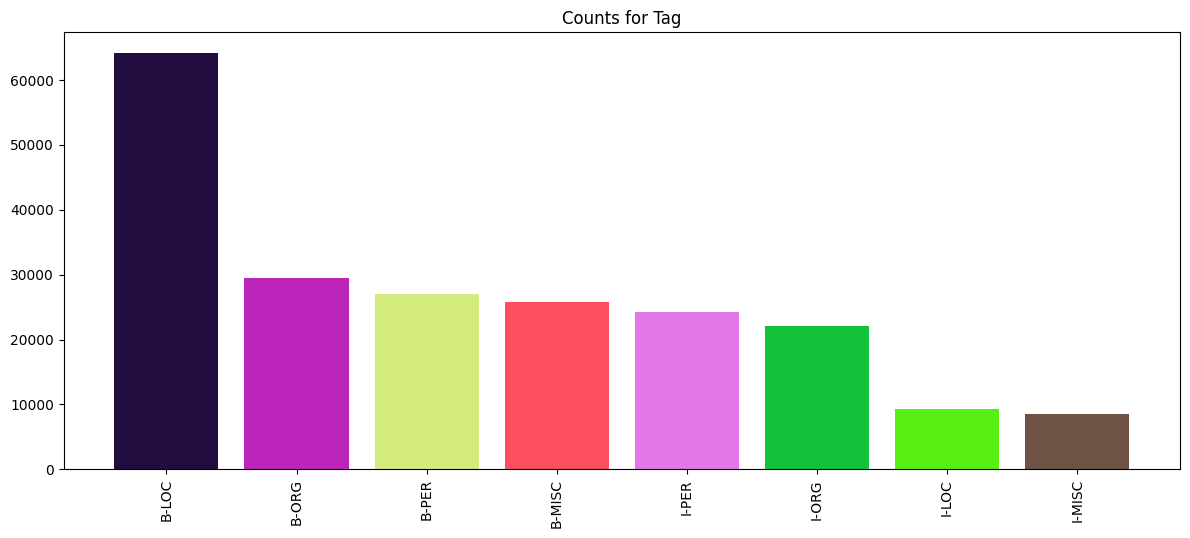

In [14]:
plt.figure(figsize=(12, 10))

def plotCounts(data, col, i):
  counter = Counter()
  data[col].apply(lambda x : counter.update(x))

  arr = sorted(builtins.zip(list(counter.values()), list(counter.keys())),
                                                    reverse=True)
  y, x = builtins.zip(*arr)

  x = list(x)
  y = list(y)
  for j in range(len(x)):
    x[j] = tag_ids_to_tag[x[j]]

  x.pop(0)
  o_count = y.pop(0)
  plt.subplot(2, 1, i)
  plt.bar(x=x, height=y, color=np.random.rand(len(arr), 3))
  plt.xticks(rotation=90, ha='center')
  plt.title("Counts for " + col)
  plt.tight_layout()

  print("Count of 'O' Tag: ", o_count)

plotCounts(ner_corpus, 'Tag', 1)

In [15]:
"Number of duplicates: " + str(sum(ner_corpus['Sentence'].duplicated()))

'Number of duplicates: 2403'

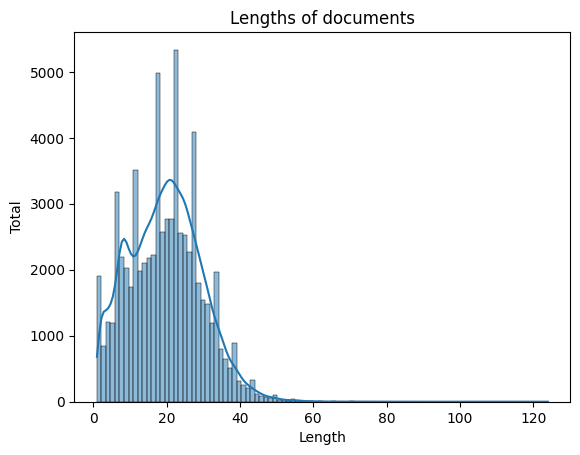

In [16]:
arr = ner_corpus['Sentence'].apply(lambda x: len(x.split())).values
sns.histplot(arr, bins=100, kde=True)
plt.title("Lengths of documents")
plt.xlabel("Length")
plt.ylabel("Total")
plt.show()

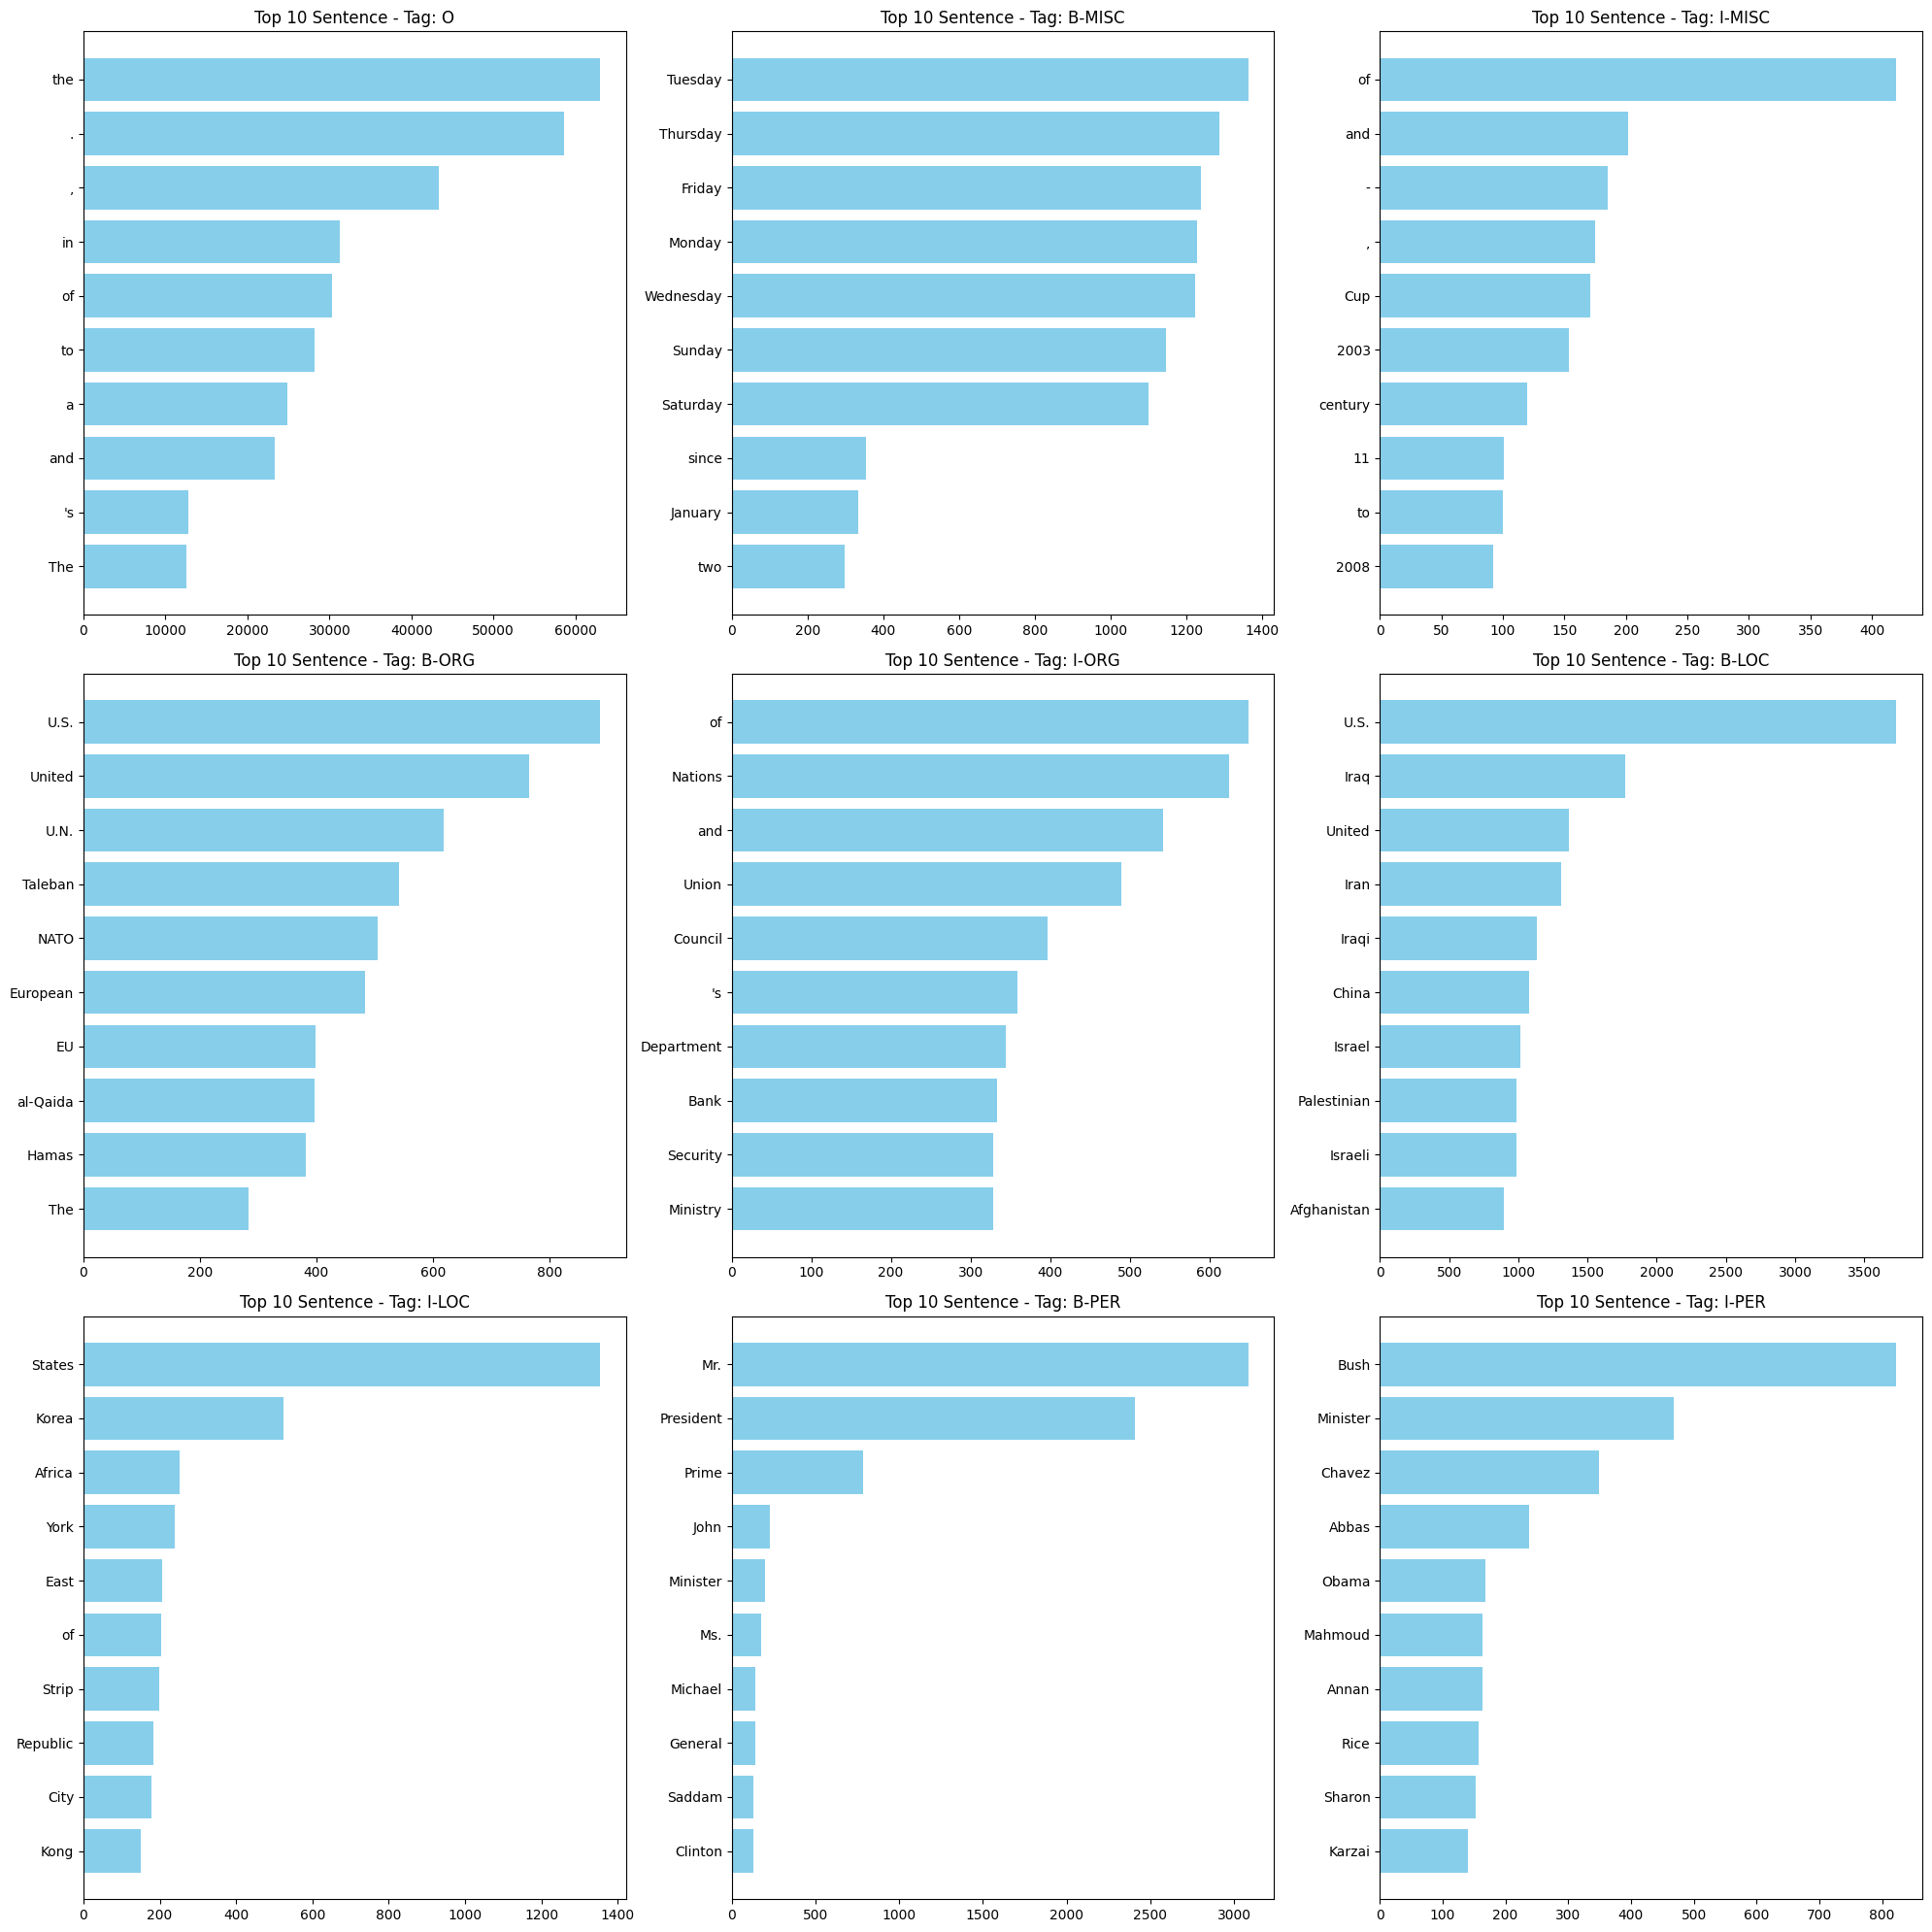

In [17]:
def topThings(data, col, compareCol, color):
  counter = defaultdict(defaultdict)
  for i in range(len(data)):
    a = list(builtins.zip(data.iloc[i][compareCol].split(),
                                        data.iloc[i][col]))
    for j in a:
      counter[j[1]][j[0]] = 1 if j[0] not in counter[j[1]] else \
                                          counter[j[1]][j[0]] + 1

  a = [sorted([(counter[i][j], i, j) for j in counter[i]],
                            reverse=True) for i in counter]

  plt.figure(figsize=(20, 20))
  c = 1
  for i in a:
    plt.subplot(3, 3, c)
    plt.barh(list(builtins.zip(*i))[2][:10][::-1],
             list(builtins.zip(*i))[0][:10][::-1], color=color)

    plt.tight_layout()
    plt.title("Top 10 "+compareCol+" - "+col+": "+tag_ids_to_tag[i[0][1]])
    c += 1

topThings(ner_corpus, 'Tag', 'Sentence', 'skyblue')

</br></br>
### Data Preprocessing and Preperation
---

In [18]:
MAX_LEN = 200
BATCH_SIZE = 32

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased',
                                          do_lower_case=False)

In [21]:
class DataPreprocessor(object):

  def __init__(self, data):
    self.data = data
    self.data_preprocessed = None
    self.tokenized = False
    self.preprocessed = False


  def tokenize_data(self, tokenizer):
    for i in range(self.data.shape[0]):
      tokens, tags = [], []
      flag = True

      for (idx, word) in enumerate(self.data.iloc[i]['Sentence'].split()):
        tokenized_word = tokenizer.tokenize(word)
        tokens.extend(tokenized_word)
        try:
          word_len = len(tokenized_word)
          tags.extend([self.data.iloc[i]['Tag'][idx]] * word_len)
        except:
          flag = False

      if flag:
        self.data.at[i, 'Sentence'] = tokens.copy()
        self.data.at[i, 'Tag'] = tags.copy()

    self.tokenized = True


  def preprocess_data(self, tokenizer, max_len, batch_size):
    sent_lens = self.data['Sentence'].apply(len)
    tag_lens = self.data['Tag'].apply(len)
    self.data = self.data[sent_lens == tag_lens]

    attention_masks = self.data['Sentence'].apply(lambda x:
                              [1.0 for i in range(len(x))])
    attention_masks_padded = pad_sequences(attention_masks,
                                           maxlen=MAX_LEN, padding='post')

    converted_sentences = self.data['Sentence'].apply(lambda x:
                              tokenizer.convert_tokens_to_ids(x))
    sentence_padded = pad_sequences(converted_sentences,
                                    maxlen=MAX_LEN, padding='post')

    tags_padded = pad_sequences(self.data['Tag'],
                                    maxlen=MAX_LEN, padding='post')

    sentence_padded = torch.tensor(sentence_padded, dtype=float)
    attention_masks_padded = torch.tensor(attention_masks_padded,
                                                     dtype=float)
    tags_padded = torch.tensor(tags_padded, dtype=float)

    tensor_data = TensorDataset(sentence_padded, attention_masks_padded,
                                                            tags_padded)

    random_sampler = RandomSampler(tensor_data)
    data_preprocessed = DataLoader(tensor_data, batch_size=batch_size,
                                               sampler=random_sampler)

    self.data_preprocessed = data_preprocessed
    self.preprocessed = True

    return self.data_preprocessed

In [22]:
data_preprocessor = DataPreprocessor(ner_corpus)
data_preprocessor.tokenize_data(tokenizer)
data_preprocessor.preprocess_data(tokenizer, MAX_LEN, BATCH_SIZE)

</br></br>
### Create and Define Models
---

In [25]:
class BiLSTM(torch.nn.Module):

  def __init__(self, tokenizer, input_dim, output_dim):
    super(BiLSTM, self).__init__()
    self.embedding = torch.nn.Embedding(len(tokenizer), 200)
    self.bilstm = torch.nn.LSTM(200, 16, bidirectional=True,
                                           batch_first=True)
    self.dropout = torch.nn.Dropout(0.2)
    self.output = torch.nn.Linear(32, output_dim)


  def forward(self, x):
    x1 = self.embedding(x)
    x2 = self.dropout(x1)

    x3 = self.bilstm(x2)[0]
    x4 = self.dropout(x3)
    output = self.output(x4)

    return output

In [26]:
class GatedCNN(torch.nn.Module):
  def __init__(self, tokenizer, input_dim, output_dim):
    super(GatedCNN, self).__init__()

    self.embedding = torch.nn.Embedding(len(tokenizer), 200)
    self.conv = torch.nn.Conv1d(200, 32, 3, padding='same')
    self.sigmoid = torch.nn.Sigmoid()
    self.dropout = torch.nn.Dropout(0.2)
    self.linear = torch.nn.Linear(32, 16)
    self.output = torch.nn.Linear(16, output_dim)


  def forward(self, x):
    x1 = self.embedding(x)
    x2 = self.dropout(x1)
    A = self.conv(x2.t())
    B = self.conv(x2.t())

    x3 = torch.multiply(A, self.sigmoid(B)).t()
    x4 = self.linear(x3)
    x5 = self.dropout(x4)
    output = self.output(x5)

    return output

In [ ]:
bert_model = BertForTokenClassification.from_pretrained(
            "bert-base-cased", num_labels=9,
            output_attentions=False, output_hidden_states=False)

</br></br>
### Train Models
---

In [28]:
def valid_acc(model, data):
  acc = []
  for (idx, batch) in enumerate(data):
    with torch.no_grad():
      outputs = model.forward(batch[0])
      target = batch[2]
      pred = torch.argmax(outputs, axis=1)

      acc.append(accuracy_score(pred, target))

  return np.mean(np.array(acc))


def train_model(model, epochs, data, val_data):
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  total_steps = len(data) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                              num_training_steps=total_steps)
  for _ in range(epochs):
    total_loss = 0

    for (idx, batch) in enumerate(data):
      batch_loss = 0
      for i in range(batch[0].shape[0]):
        cur_data = batch[0][i].long().unsqueeze(0).long()[0]
        output = model.forward(cur_data)

        pred = torch.argmax(output, axis=1)
        target = batch[2][i].long()

        batch_loss += loss_fn(output, target)

      batch_loss.backward()
      optimizer.step()
      scheduler.step()

      cur_val_acc = valid_acc()
      print("Batch: ", idx, "   Loss: ", batch_loss.item(),
                                     "   Valid accuracy: ",
                                          cur_val_acc, "%")

In [29]:
def train_bert_model(model, epochs, data):
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  total_steps = len(data) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                              num_training_steps=total_steps)
  for _ in range(epochs):
    model.train()
    total_loss = 0
    for (idx, batch) in enumerate(data):
      model.zero_grad()
      outputs = model(batch[0].long(), token_type_ids=None,
                            attention_mask=batch[1].long(),
                                    labels=batch[2].long())
      loss = outputs[0]
      total_loss += loss
      loss.backward()

      torch.nn.utils.clip_grad_norm(parameters=model.parameters(),
                                                    max_norm=1.0)
      optimizer.step()
      scheduler.step()


In [ ]:
bilstm = BiLSTM(tokenizer, 200, 9)
gatedcnn = GatedCNN(tokenizer, 200, 9)

epochs = 3

train_model(bilstm, epochs, data_preprocessor.data_preprocessed)
train_model(gatedcnn, epochs, data_preprocessor.data_preprocessed)
train_bert_model(bert_model, 1, data_preprocessor.data_preprocessed)

In [ ]:
train_bert_model(bert_model, 1, data_preprocessor.data_preprocessed)